<a href="https://colab.research.google.com/github/akhilabojja/AI/blob/main/AI_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests

def fetch_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None

def print_column_names(data):
    if isinstance(data, list) and len(data) > 0:
        # Assuming the first item in the list is representative of the structure
        first_item = data[0]
        print("Column names:", first_item.keys())
    elif isinstance(data, dict):
        print("Column names:", data.keys())
    else:
        print("No valid data found.")

def main():
    urls = [
        "https://www.jsonkeeper.com/b/LLQT",
        "https://api.jsonserve.com/rJvd7g",
        "https://api.jsonserve.com/XgAgFJ"
    ]

    for url in urls:
        data = fetch_data(url)
        print(f"\nColumn names for {url}:")
        print_column_names(data)

if __name__ == "__main__":
    main()


Column names for https://www.jsonkeeper.com/b/LLQT:
Column names: dict_keys(['quiz'])

Column names for https://api.jsonserve.com/rJvd7g:
Column names: dict_keys(['id', 'quiz_id', 'user_id', 'submitted_at', 'created_at', 'updated_at', 'score', 'trophy_level', 'accuracy', 'speed', 'final_score', 'negative_score', 'correct_answers', 'incorrect_answers', 'source', 'type', 'started_at', 'ended_at', 'duration', 'better_than', 'total_questions', 'rank_text', 'mistakes_corrected', 'initial_mistake_count', 'response_map', 'quiz', 'next_steps'])

Column names for https://api.jsonserve.com/XgAgFJ:
Column names: dict_keys(['id', 'quiz_id', 'user_id', 'submitted_at', 'created_at', 'updated_at', 'score', 'trophy_level', 'accuracy', 'speed', 'final_score', 'negative_score', 'correct_answers', 'incorrect_answers', 'source', 'type', 'started_at', 'ended_at', 'duration', 'better_than', 'total_questions', 'rank_text', 'mistakes_corrected', 'initial_mistake_count', 'response_map', 'quiz'])


In [27]:
import pandas as pd
import requests

def fetch_data(url):
    """Fetch JSON data from a given URL."""
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None

def process_quiz_data(current_data, historical_data):
    """Process current and historical quiz data into DataFrames."""
    print("Raw Current Data:", current_data)
    print("Raw Historical Data:", historical_data)

    # Create DataFrames from the fetched data
    current_df = pd.DataFrame(current_data)
    historical_df = pd.DataFrame(historical_data)

    # Print the structure of the DataFrames for debugging
    print("Current DataFrame Structure:\n", current_df.head())
    print("Historical DataFrame Structure:\n", historical_df.head())

    # Rename 'quiz' column to 'topic' for consistency
    if 'quiz' in current_df.columns:
        current_df.rename(columns={'quiz': 'topic'}, inplace=True)
    if 'quiz' in historical_df.columns:
        historical_df.rename(columns={'quiz': 'topic'}, inplace=True)

    # Ensure 'topic' is a string to avoid issues during grouping
    current_df['topic'] = current_df['topic'].astype(str)
    historical_df['topic'] = historical_df['topic'].astype(str)

    return current_df, historical_df

def analyze_performance(current_df, historical_df):
    """Analyze performance based on current and historical data."""
    # Check for necessary columns
    if 'correct_answers' not in current_df.columns or 'total_questions' not in current_df.columns:
        print("Error: 'correct_answers' or 'total_questions' not found in current_df")
        return None, None
    if 'correct_answers' not in historical_df.columns or 'total_questions' not in historical_df.columns:
        print("Error: 'correct_answers' or 'total_questions' not found in historical_df")
        return None, None

    # Calculate accuracy
    current_df['accuracy'] = current_df['correct_answers'] / current_df['total_questions']
    historical_df['accuracy'] = historical_df['correct_answers'] / historical_df['total_questions']

    # Group by topic to analyze performance
    current_performance = current_df.groupby(['topic']).agg(
        accuracy=('accuracy', 'mean'),
        attempts=('total_questions', 'sum')
    ).reset_index()

    historical_performance = historical_df.groupby(['topic']).agg(
        accuracy=('accuracy', 'mean'),
        attempts=('total_questions', 'sum')
    ).reset_index()

    return current_performance, historical_performance

def generate_insights(current_performance, historical_performance):
    """Generate insights based on performance data."""
    insights = []

    # Identify weak areas
    weak_areas = current_performance[current_performance['accuracy'] < 0.5]
    if not weak_areas.empty:
        insights.append("Weak Areas: Topics with less than 50% accuracy:")
        insights.append(weak_areas[['topic', 'accuracy', 'attempts']].to_string(index=False))

    # Improvement trends
    improvement_trends = current_performance.merge(historical_performance, on=['topic'], suffixes=('_current', '_historical'))
    improvement_trends['improvement'] = improvement_trends['accuracy_current'] - improvement_trends['accuracy_historical']
    improved_topics = improvement_trends[improvement_trends['improvement'] > 0]
    if not improved_topics.empty:
        insights.append("Improvement Trends: Topics with improvement:")
        insights.append(improved_topics[['topic', 'improvement']].to_string(index=False))

    # Performance gaps
    performance_gaps = historical_performance.merge(current_performance, on=['topic'], suffixes=('_historical', '_current'))
    performance_gaps['gap'] = performance_gaps['accuracy_current'] - performance_gaps['accuracy_historical']
    gaps = performance_gaps[performance_gaps['gap'] < 0]
    if not gaps.empty:
        insights.append("Performance Gaps: Topics with decreased performance:")
        insights.append(gaps[['topic', 'gap']].to_string(index=False))

    return insights

def create_recommendations(current_performance):
    """Create recommendations based on performance data."""
    recommendations = []

    # Suggest topics to focus on based on weak areas
    weak_areas = current_performance[current_performance['accuracy'] < 0.5]
    if not weak_areas.empty:
        recommendations.append("Recommended Topics to Focus On:")
        recommendations.append(weak_areas[['topic', 'accuracy']].to_string(index=False))

    return recommendations

def analyze_student_persona(current_performance):
    """Analyze and define the student persona based on performance patterns."""
    persona = {}
    average_accuracy = current_performance['accuracy'].mean()

    if average_accuracy >= 0.75:
        persona['label'] = 'High Achiever'
        persona['description'] = 'You have a strong grasp of the material. Keep up the great work!'
    elif average_accuracy >= 0.5:
        persona['label'] = 'Average Performer'
        persona['description'] = 'You are doing well, but there are areas to improve. Focus on weak topics.'
    else:
        persona['label'] = 'Struggling Learner'
        persona['description'] = 'You may need additional support. Consider revisiting foundational topics.'

    return persona

def main():
    """Main function to execute the analysis."""
    # Define URLs for current and historical quiz data
    current_quiz_url_1 = "https://www.jsonkeeper.com/b/LLQT"
    current_quiz_url_2 = "https://api.jsonserve.com/rJvd7g"
    historical_quiz_url = "https://api.jsonserve.com/XgAgFJ"

    # Fetch current and historical quiz data
    current_quiz_data_1 = fetch_data(current_quiz_url_1)
    current_quiz_data_2 = fetch_data(current_quiz_url_2)
    historical_quiz_data = fetch_data(historical_quiz_url)

    if current_quiz_data_1 and current_quiz_data_2 and historical_quiz_data:
        # Ensure both current quiz datasets are lists
        if isinstance(current_quiz_data_1, dict):
            current_quiz_data_1 = [current_quiz_data_1]
        if isinstance(current_quiz_data_2, dict):
            current_quiz_data_2 = [current_quiz_data_2]

        # Combine the two sets of current quiz data
        combined_current_data = current_quiz_data_1 + current_quiz_data_2

        # Process the quiz data
        current_df, historical_df = process_quiz_data(combined_current_data, historical_quiz_data)

        # Analyze performance
        current_performance, historical_performance = analyze_performance(current_df, historical_df)

        if current_performance is not None and historical_performance is not None:
            # Generate insights
            insights = generate_insights(current_performance, historical_performance)
            print("\nInsights:")
            for insight in insights:
                print(f"- {insight}")

            # Create recommendations
            recommendations = create_recommendations(current_performance)
            print("\nRecommendations:")
            for recommendation in recommendations:
                print(f"- {recommendation}")

            # Analyze student persona
            persona = analyze_student_persona(current_performance)
            print("\nStudent Persona:")
            print(f"Label: {persona['label']}")
            print(f"Description: {persona['description']}")

if __name__ == "__main__":
    main()

Raw Current Data: [{'quiz': {'id': 43, 'name': None, 'title': 'Structural Organisation in Animals and Plants (7)', 'description': '', 'difficulty_level': None, 'topic': 'Structural Organisation in Animals', 'time': '2024-07-03T00:00:00.000+05:30', 'is_published': True, 'created_at': '2024-07-03T11:00:08.958+05:30', 'updated_at': '2024-09-23T18:43:27.751+05:30', 'duration': 128, 'end_time': '2024-07-04T00:00:00.000+05:30', 'negative_marks': '1.0', 'correct_answer_marks': '4.0', 'shuffle': True, 'show_answers': True, 'lock_solutions': False, 'is_form': False, 'show_mastery_option': False, 'quiz_type': None, 'is_custom': False, 'banner_id': None, 'exam_id': None, 'show_unanswered': False, 'ends_at': '2025-01-18', 'lives': None, 'live_count': 'Free Test', 'coin_count': -1, 'questions_count': 128, 'daily_date': 'January 17, 2025', 'max_mistake_count': 15, 'questions': [{'id': 1827, 'description': 'The tissue which has free surface that faces either a body fluid or the outside environment is

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


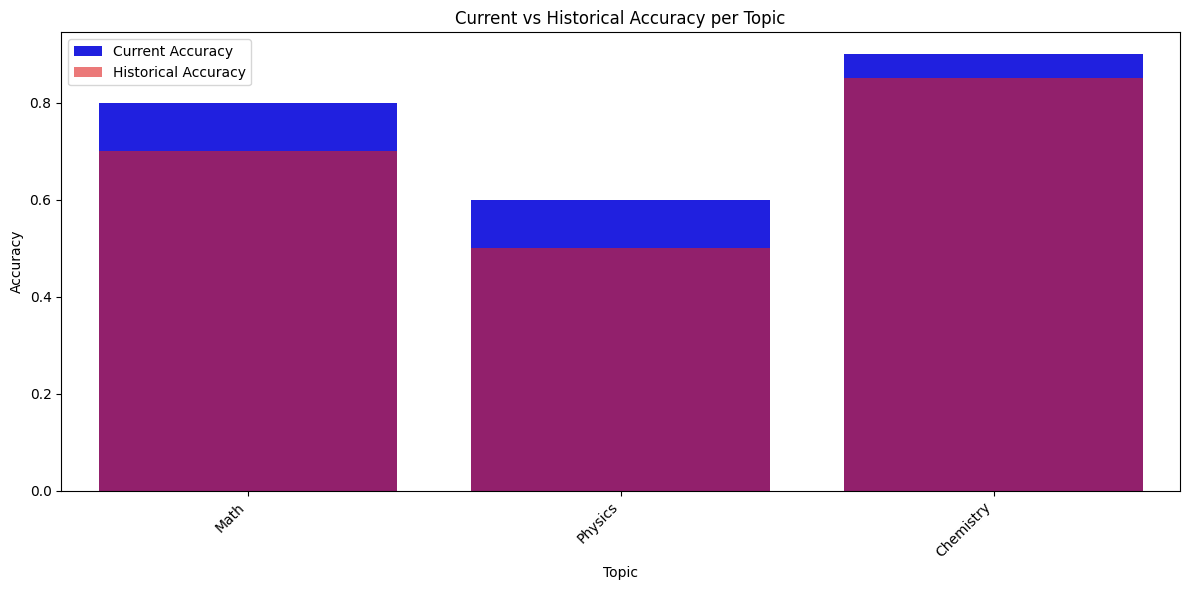

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_performance_trends(current_performance, historical_performance):
    """Plot performance trends based on accuracy."""
    performance_comparison = current_performance.merge(historical_performance, on='topic', suffixes=('_current', '_historical'))
    plt.figure(figsize=(12, 6))
    sns.barplot(x='topic', y='accuracy_current', data=performance_comparison, color='blue', label='Current Accuracy')
    sns.barplot(x='topic', y='accuracy_historical', data=performance_comparison, color='red', label='Historical Accuracy', alpha=0.6)
    plt.title('Current vs Historical Accuracy per Topic')
    plt.xlabel('Topic')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call with example data
plot_performance_trends(current_performance, historical_performance)


In [29]:
def plot_weak_areas(current_performance):
    """Plot weak areas (topics with less than 50% accuracy)."""
    weak_areas = current_performance[current_performance['accuracy'] < 0.5]
    if not weak_areas.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='topic', y='accuracy', data=weak_areas, color='orange')
        plt.title('Weak Areas (Accuracy < 50%)')
        plt.xlabel('Topic')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Call with example data
plot_weak_areas(current_performance)



<ipython-input-30-1cc7cbddbb83>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='topic', y='improvement', data=improvement_trends, palette='coolwarm')


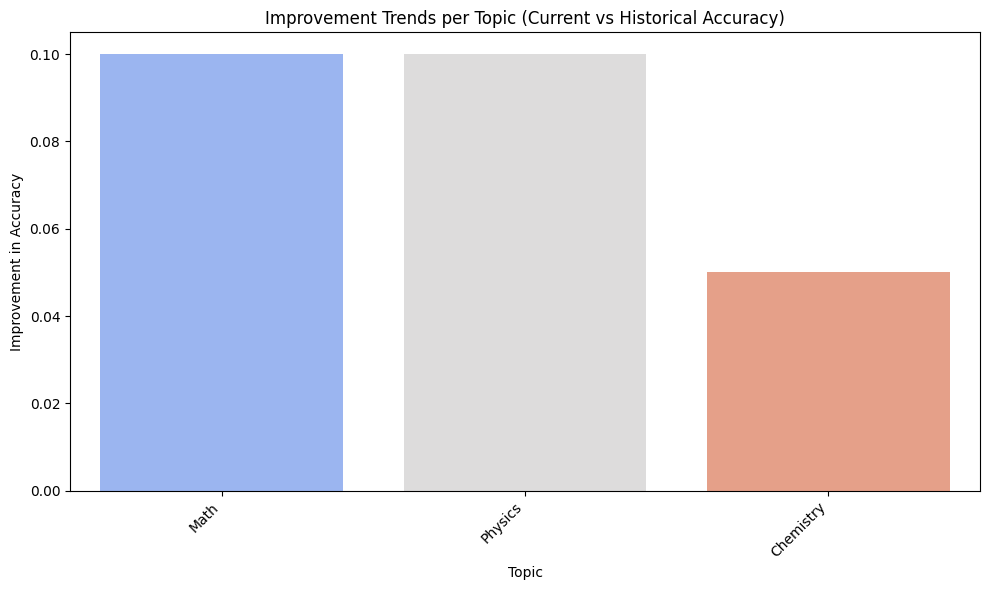

In [30]:
def plot_improvement_trends(improvement_trends):
    """Plot improvement trends in accuracy from historical to current performance."""
    plt.figure(figsize=(10, 6))
    sns.barplot(x='topic', y='improvement', data=improvement_trends, palette='coolwarm')
    plt.title('Improvement Trends per Topic (Current vs Historical Accuracy)')
    plt.xlabel('Topic')
    plt.ylabel('Improvement in Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Assuming you already have improvement_trends DataFrame
plot_improvement_trends(improvement_trends)
